### Geospatial Analysis of Deforestation in Ross-Bethio, Senegal

### Step 1: Authentication and Initial Setup

#### Import necessary libraries


In [1]:
import getpass
from datetime import datetime
from pathlib import Path
import requests
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipyleaflet import GeoJSON, Map, basemaps
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
)
from sklearn.metrics import accuracy_score
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

/Users/teo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/teo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
!pip install ipyleaflet
!pip install sentinelhub
# Install and import xarray for processing geospatial data
!pip install --upgrade rioxarray xarray

#### Step 1.1: Set up Sentinel Hub Authentication
Obtain access to Sentinel-2 satellite imagery through Copernicus Data Space Ecosystem (CDSE)


In [3]:
client_id = 'sh-f46f3159-776f-47e0-9151-dd0e2c174c62'  # Your client ID
client_secret = 'abytxtLIRebJZMr7qQa2QvN4RseaJ3wg'  # Your client secret

Create a session using OAuth2 for authentication

In [4]:
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)


Fetch access token for the session to interact with Sentinel Hub API


In [5]:
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret, 
    include_client_id=True
)

Print the available configurations to verify the connection

In [6]:
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


Define the geographical area of interest (Ross-Bethio, Senegal)
Coordinates for the bounding box

In [7]:
bbox_coords = [-16.106436, 16.305659, -16.063005, 16.335642]
# Convert coordinates to EPSG:3035 (meters as units) for spatial analysis
epsg = 3035
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)
x, y = bbox.transform(4326).middle

#### Step 1.2: Visualize the Area on a Map

In [8]:
# Display the region using an OpenStreetMap (OSM) background map
overview_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(y, x), zoom=10)
# Add the bounding box as a GeoJSON layer
geo_json = GeoJSON(data=bbox.transform(4326).geojson)
overview_map.add_layer(geo_json)
overview_map  # Display the map

Map(center=[16.320650486506196, -16.084720499999996], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Step 2: Data Acquisition

#####  Step 2.1: Create Sentinel Hub Configuration

In [9]:
# Set up Sentinel Hub configuration with your credentials
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

# Set the desired resolution of the data (100x100 meters)
resolution = (100, 100)

#### Step 3: JavaScript Code for Cloudless Imagery
This JavaScript code filters cloudless images and computes the NDVI

In [10]:
evalscript_cloudless = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "B02", "SCL"],
        output: {
            bands: 4,
            sampleType: "INT16"
        },
        mosaicking: "ORBIT"
    }
}

function getFirstQuartileValue(values) {
    values.sort((a,b) => a-b);
    return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
    var index = Math.floor(sortedValues.length / 4);
    return sortedValues[index];
}

function validate(sample) {
    // Define codes as invalid:
    const invalid = [
        0, // NO_DATA
        1, // SATURATED_DEFECTIVE
        3, // CLOUD_SHADOW
        7, // CLOUD_LOW_PROBA
        8, // CLOUD_MEDIUM_PROBA
        9, // CLOUD_HIGH_PROBA
        10 // THIN_CIRRUS
    ]
    return !invalid.includes(sample.SCL)
}

function evaluatePixel(samples) {
    var valid = samples.filter(validate);
    if (valid.length > 0 ) {
        let cloudless = {
            b08: getFirstQuartileValue(valid.map(s => s.B08)),
            b04: getFirstQuartileValue(valid.map(s => s.B04)),
            b03: getFirstQuartileValue(valid.map(s => s.B03)),
            b02: getFirstQuartileValue(valid.map(s => s.B02)),
        }
        let ndvi = ((cloudless.b08 - cloudless.b04) / (cloudless.b08 + cloudless.b04))
        // This applies a scale factor so the data can be saved as an int
        let scale = [cloudless.b04, cloudless.b03, cloudless.b02, ndvi].map(v => v*10000);
        return scale
    }
    // If there isn't enough data, return NODATA
    return [-32768, -32768, -32768, -32768]
}
"""

### Step 4: Data Request and Download

Define time intervals (June to September) for the vegetation season

In [11]:
def interval_of_interest(year):
    return (datetime(year, 6, 1), datetime(year, 9, 1))


Function to create a data request for a specific year

In [12]:
def get_request(year):
    time_interval = interval_of_interest(year)
    return SentinelHubRequest(
        evalscript=evalscript_cloudless,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=resolution,
        config=config,
        data_folder="./data",
    )

Create a dictionary of requests

In [13]:
sh_requests = {}
for year in range(2018, 2024):
    sh_requests[year] = get_request(year)

sh_requests

{2018: <sentinelhub.api.process.SentinelHubRequest at 0x7fd8685b0970>,
 2019: <sentinelhub.api.process.SentinelHubRequest at 0x7fd86197aa90>,
 2020: <sentinelhub.api.process.SentinelHubRequest at 0x7fd86856dfa0>,
 2021: <sentinelhub.api.process.SentinelHubRequest at 0x7fd86856dd60>,
 2022: <sentinelhub.api.process.SentinelHubRequest at 0x7fd86856db20>,
 2023: <sentinelhub.api.process.SentinelHubRequest at 0x7fd86856d700>}

In [14]:
list_of_requests = [request.download_list[0] for request in sh_requests.values()]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

In [15]:
def request_output_path(request):
    # Gets the full path to the output from a request
    return Path(request.data_folder, request.get_filename_list()[0])


# Moves and renames the files to the root directory of results
for year, request in sh_requests.items():
    request_output_path(request).rename(f"./data/{year}.tif")

### Step 5: Data Processing and Visualization with Xarray

In [19]:

# Pre-process the files to add the correct year as a time dimension
def add_time_dim(xda):
    year = int(Path(xda.encoding["source"]).stem)
    return xda.expand_dims(year=[year])

# Load all TIFF files into an xarray dataset
tiff_paths = Path("./data").glob("*.tif")
ds_s2 = xr.open_mfdataset(
    tiff_paths,
    engine="rasterio",
    preprocess=add_time_dim,
    band_as_variable=True,
)

# Rename bands for better readability
ds_s2 = ds_s2.rename(
    {
        "band_1": "R",
        "band_2": "G",
        "band_3": "B",
        "band_4": "NDVI",
    }
)

# Scale data for plotting and analysis
ds_s2 = ds_s2 / 10000

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

#### Step 6: Visualize NDVI Over Time
Plot NDVI values for each year

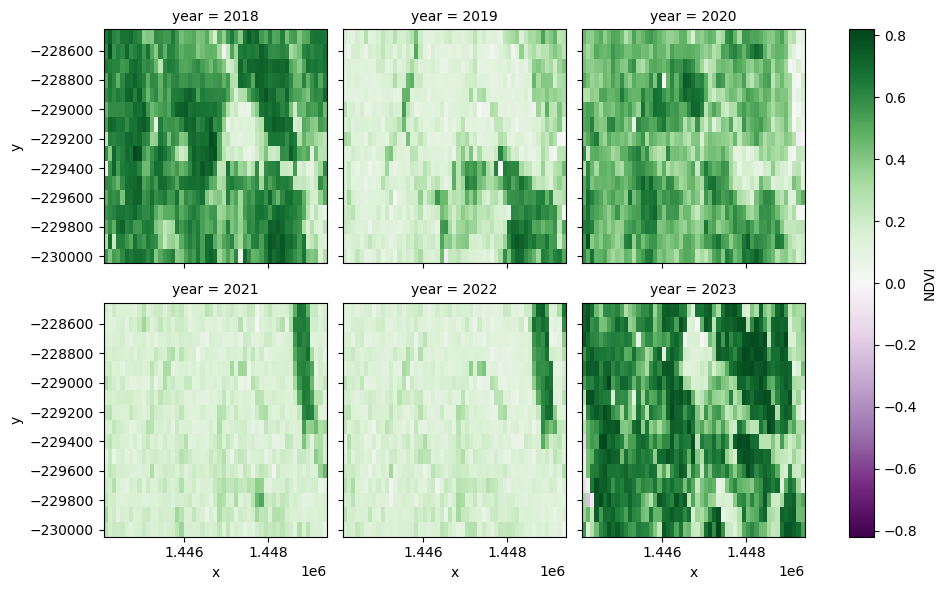

In [20]:
ds_s2.NDVI.plot(cmap="PRGn", x="x", y="y", col="year", col_wrap=3)

#### Step 7: True Color Visualization
Display the true color image for a specific year (e.g., 2018)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True Color 2018')

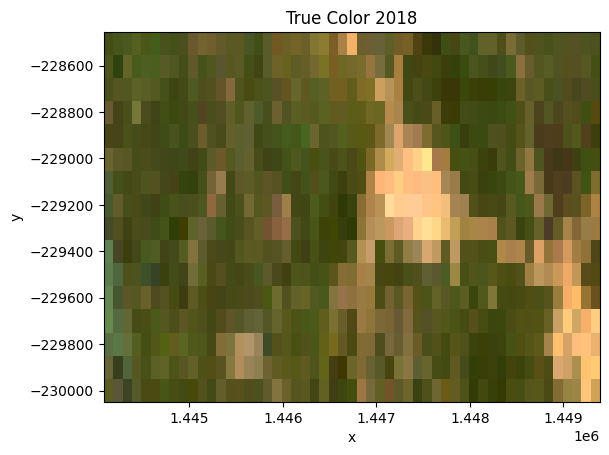

In [21]:

plot_year = 2018
true_color = ds_s2.sel(year=plot_year)[["R", "G", "B"]].to_array()
(true_color * 4).plot.imshow()
plt.title(f"True Color {plot_year}")


#### Step 8: Forest Classification and Change Detection

In [23]:

# Classify forested areas using NDVI (NDVI > 0.7)
ds_s2["FOREST"] = ds_s2.NDVI > 0.7

# Function to calculate forest area in square kilometers (km²)
def to_km2(dataarray, resolution):
    return dataarray * np.prod(list(resolution)) / 1e6

# Calculate and plot the forest area over time
forest_pixels = ds_s2.FOREST.sum(["x", "y"])
forest_pixels

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
dask.array<sum-aggregate, shape=(6,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year         (year) int64 48B 2018 2019 2020 2021 2022 2023
    spatial_ref  int64 8B 0

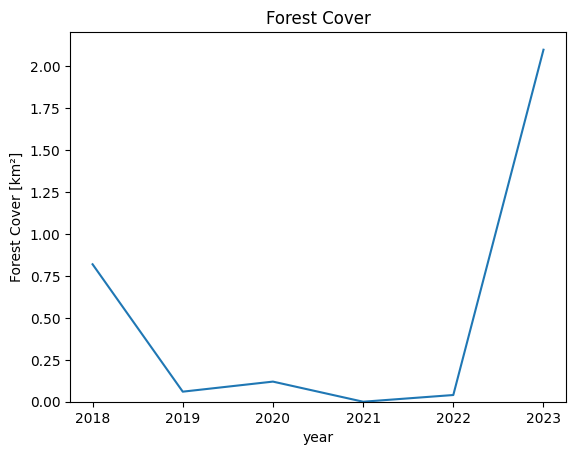

In [24]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6


forest_pixels = ds_s2.FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2.plot()
plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

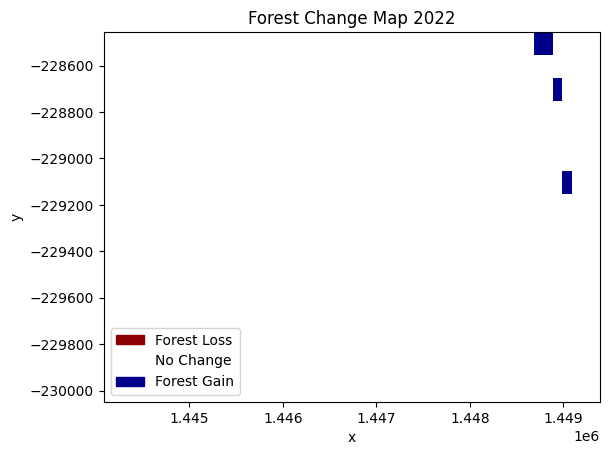

In [25]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

plot_year = 2022
ds_s2["CHANGE"] = ds_s2.FOREST.astype(int).diff("year", label="upper")
ds_s2.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");